In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pickle

from constants.constants import *
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from IPython.display import HTML

# Embeds graphs in Jupyter notebook (instead of pop-ups)
%matplotlib inline

# pd.set_option('display.max_columns', None) # show all columns

Try using Random Forest with Boruta Preprocessor to predict wins and losses

### Note: If the model does not exist, please run `03_feature_selection.ipynb`

In [2]:
with open(BORUTA_FEATURES_PATH, 'r') as f:
    selected_features = json.load(f)
with open('data/machine_learning/pkl/processor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

df_train_preprocessed, df_test_preprocessed, y_train_encoded, y_test_encoded = preprocessor.get_processed_data() # contains team details
df_train_preprocessed_features = df_train_preprocessed[selected_features]
df_test_preprocessed_features = df_test_preprocessed[selected_features]

Preprocess the Predicted Data as well

In [3]:
prediction_df = pd.read_csv('data/machine_learning/2023_predict.csv')
prediction_df = preprocessor.fit_data_to_predict(prediction_df)
prediction_df = prediction_df[['team', 'opponent', 'country', *selected_features]]

Draws seem to be harder to predict because they are underrepresented in the labels, so we balance the sample

In [4]:
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Store the metrics for each model in a dictionary
model_metrics = {}

### Helper Function

In [5]:
def evaluate_model(model, X_train, y_train, X_test, y_test, df_2023, supports_sample_weight=True):

    if supports_sample_weight:
        model.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    model_name = model.__class__.__name__

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)

    print(f"Model: {model_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    model_metrics[model_name] = metrics

    report = classification_report(y_test, predictions, target_names=preprocessor.target_encoder.classes_, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Style the DataFrame
    styled_df = report_df.style.set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])

    print(f"\nClassification Report for {model_name}:")
    display(styled_df)

    print(f"Confusion Matrix for {model_name}")
    encoded_labels = np.unique(np.concatenate((y_test, predictions)))
    labels = preprocessor.target_encoder.inverse_transform(encoded_labels)
    conf_mat = confusion_matrix(y_test, predictions, labels=encoded_labels)
    plt.figure(figsize=(5, 3))  # Size of the figure
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    df_copy = df_test_preprocessed.copy()
    df_copy['actual_result'] = preprocessor.target_encoder.inverse_transform(y_test)
    predicted_labels = preprocessor.target_encoder.inverse_transform(predictions)
    df_copy['predicted_result'] = predicted_labels
    # display(df_copy[['country', 'team', 'opponent', 'is_home', 'predicted_result']])

    df_2023_copy = df_2023.copy()
    predictions_2023 = model.predict(df_2023.drop(['team', 'opponent', 'country'], axis=1))
    predicted_labels_2023 = preprocessor.target_encoder.inverse_transform(predictions_2023)
    df_2023_copy['predicted_result'] = predicted_labels_2023
    final_df = df_2023_copy[['country', 'team', 'opponent', 'is_home', 'predicted_result']]
    final_df.to_csv(f"./data/machine_learning/predictions/{model_name}.csv", index=False)

<h5>The following models are among the most popular and widely used for classification tasks.</h5>

<table border="1">
    <thead>
        <tr>
            <th>Group</th>
            <th>Model Name</th>
            <th>Description</th>
            <th>Best For</th>
            <th>Limitations</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Linear Model</td>
            <td>LogisticRegression</td>
            <td>Uses a linear decision boundary to classify data</td>
            <td>Problems where relationships between features and outcomes can be linearly approximated. Works well when data is linearly separable.</td>
            <td>Performs poorly if relationships are highly non-linear without feature transformation.</td>
        </tr>
        <tr>
            <td>Single Tree Model</td>
            <td>DecisionTreeClassifier</td>
            <td>Uses a single decision tree</td>
            <td>Interpretable models; good for data with complex relationships but not too many features.</td>
            <td>Prone to overfitting; sensitive to small changes in the data.</td>
        </tr>
        <tr>
            <td>Tree-Based Ensemble Models</td>
            <td>RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier</td>
            <td>Built upon decision trees, utilizing multiple trees to improve prediction accuracy and control over-fitting.</td>
            <td>Robust against overfitting; can handle both linear and non-linear data; suitable for mixed data types.</td>
            <td>Computationally intensive; less interpretable due to complexity (especially boosting).</td>
        </tr>
        <tr>
            <td>Probabilistic Model</td>
            <td>GaussianNB</td>
            <td>Uses statistical probability to make predictions.</td>
            <td>Quick baseline models; effective when features have a Gaussian distribution.</td>
            <td>Assumes independence between features, which can lead to poor performance when violated.</td>
        </tr>
        <tr>
            <td>Instance-Based Model</td>
            <td>KNeighborsClassifier</td>
            <td>Uses the distances between data points to make predictions.</td>
            <td>Effective for datasets where similar cases have similar outcomes; not too large datasets.</td>
            <td>Struggles with high-dimensional data; computationally expensive.</td>
        </tr>
        <tr>
            <td>Kernel-Based Model</td>
            <td>SVC</td>
            <td>Transforms data into a higher-dimensional space, making it possible to perform linear separation in that space.</td>
            <td>Complex problems where the decision boundary is not linear; effective in higher-dimensional spaces.</td>
            <td>Computationally intensive; requires careful parameter tuning and kernel selection.</td>
        </tr>
    </tbody>
</table>

### Logistic Regression

`Linear Relationship`: Logistic Regression in a multi-class setting still computes a linear combination of the input features (weighted sum plus bias), but it does this for each class separately in the One-vs-Rest (OvR) scheme.

`Softmax Function`: For multi-class classification, the sigmoid function used in binary classification is replaced by the softmax function. The softmax function is used to handle multiple classes and is a generalization of the sigmoid. It outputs a probability distribution across all classes. For each instance, the probabilities sum up to 1 across all possible outcomes (D, L, W).

`Decision Rule`: In multi-class Logistic Regression, the predicted class for an observation is simply the class with the highest probability after applying the softmax function.

Model: LogisticRegression
Accuracy: 0.5024288688410826
Precision: 0.517026112386633
Recall: 0.5024288688410826
F1 Score: 0.508562468947365

Classification Report for LogisticRegression:


,precision,recall,f1-score,support
D,0.289082,0.350904,0.317007,664.000000
L,0.590196,0.551787,0.570346,1091.000000
W,0.580492,0.543922,0.561612,1127.000000
accuracy,0.502429,0.502429,0.502429,0.502429
macro avg,0.486590,0.482204,0.482988,2882.000000
weighted avg,0.517026,0.502429,0.508562,2882.000000


Confusion Matrix for LogisticRegression


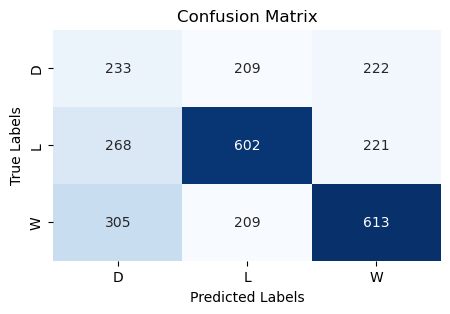

In [6]:
from sklearn.linear_model import LogisticRegression
evaluate_model(LogisticRegression(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### Decision Tree

`Tree Construction`: The model builds the tree by splitting the data into branches based on feature values. These splits are made at points that most effectively separate the different classes based on a specific metric, typically Gini impurity or entropy for classification tasks.
- The tree will choose splits that decrease Gini impurity the most across the branches.
- Entropy measures the amount of information disorder or uncertainty; the goal is to split the subsets such that the entropy decreases most rapidly towards zero

`Recursive Splitting`: The process starts at the root of the tree and splits the data recursively on feature values. Each node represents a decision point, and each branch represents the outcome of that decision, leading to leaves that represent classifications or further splits.

`Stopping Criteria`: The tree stops growing when it reaches a preset depth, a minimum number of samples per leaf, or if no further gain can be made from further splits (among other criteria). This prevents overfitting, which is common with decision trees due to their tendency to fit detailed data specifics rather than general trends.

`Prediction`: Once the tree is built, predictions are made by passing new data points through the tree, starting from the root and making decisions at each node based on its features until a leaf node (a final class label) is reached.

Model: DecisionTreeClassifier
Accuracy: 0.4226231783483692
Precision: 0.4297667041199092
Recall: 0.4226231783483692
F1 Score: 0.42580107249568133

Classification Report for DecisionTreeClassifier:


,precision,recall,f1-score,support
D,0.248670,0.281627,0.264124,664.000000
L,0.478303,0.454629,0.466165,1091.000000
W,0.489478,0.474712,0.481982,1127.000000
accuracy,0.422623,0.422623,0.422623,0.422623
macro avg,0.405484,0.403656,0.404091,2882.000000
weighted avg,0.429767,0.422623,0.425801,2882.000000


Confusion Matrix for DecisionTreeClassifier


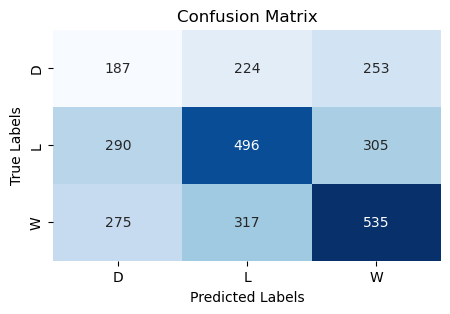

In [7]:
from sklearn.tree import DecisionTreeClassifier
evaluate_model(DecisionTreeClassifier(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### Random Forest Classifier

`Ensemble of Decision Trees`: A RandomForestClassifier operates by constructing a multitude of decision trees during the training phase. Each tree is built from a random sample of the training data, which helps ensure that the trees are diverse and that the model is robust against overfitting.

`Random Selection of Features`: At each split in the construction of a tree, a random subset of the features is chosen to decide the best split among them. This randomness helps in creating more varied trees and contributes to the model's strength in handling complex datasets with many features.

`Voting Mechanism`: For prediction, each tree in the forest votes for a class (W, D, or L in your case), and the class receiving the most votes becomes the model’s prediction. This is an example of a majority voting system, which leverages the collective decision-making of all the trees in the forest.

`Probabilistic Nature`: The model can also provide probabilities for each class, indicating the likelihood of each possible outcome according to the different trees in the forest. This is derived from the proportion of trees that vote for each class.

Model: RandomForestClassifier
Accuracy: 0.4750173490631506
Precision: 0.4651722133848868
Recall: 0.4750173490631506
F1 Score: 0.4691437673337992

Classification Report for RandomForestClassifier:


,precision,recall,f1-score,support
D,0.274725,0.225904,0.247934,664.000000
L,0.512175,0.559120,0.534619,1091.000000
W,0.531878,0.540373,0.536092,1127.000000
accuracy,0.475017,0.475017,0.475017,0.475017
macro avg,0.439593,0.441799,0.439548,2882.000000
weighted avg,0.465172,0.475017,0.469144,2882.000000


Confusion Matrix for RandomForestClassifier


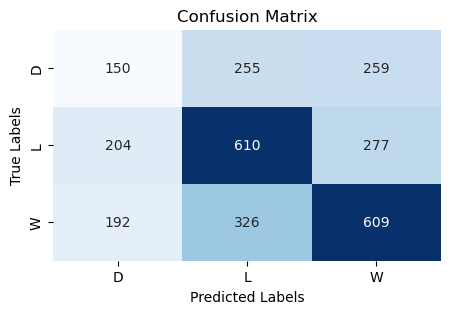

In [8]:
from sklearn.ensemble import RandomForestClassifier
evaluate_model(RandomForestClassifier(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### Extra Trees

`Randomized Trees`: Like RandomForest, ExtraTrees builds multiple trees using subsets of the data but it randomizes the cuts more. It selects split points completely at random for each feature during the construction of the trees, rather than looking for the most informative thresholds.

`No Bootstrapping`: Unlike RandomForest which uses bootstrapped samples (sampling with replacement), ExtraTrees uses the whole original sample which might lead to lower variance in the model.

`Ensemble Method`: It constructs a multitude of decision trees at training time and outputs the class that is the mode of the classes (classification) of the individual trees.

`Parallel Construction`: The trees are constructed in parallel during training phase. This parallelism is a key point in the speed of the algorithm.

`Prediction`: For a given input, each tree in the Extra Trees ensemble makes a prediction and the final class prediction is the one that receives the majority vote from all the trees.

Model: ExtraTreesClassifier
Accuracy: 0.4902845246356697
Precision: 0.4707347637346044
Recall: 0.4902845246356697
F1 Score: 0.47755750031672634

Classification Report for ExtraTreesClassifier:


,precision,recall,f1-score,support
D,0.267857,0.180723,0.215827,664.000000
L,0.522727,0.590284,0.554455,1091.000000
W,0.539933,0.575865,0.557321,1127.000000
accuracy,0.490285,0.490285,0.490285,0.490285
macro avg,0.443506,0.448957,0.442535,2882.000000
weighted avg,0.470735,0.490285,0.477558,2882.000000


Confusion Matrix for ExtraTreesClassifier


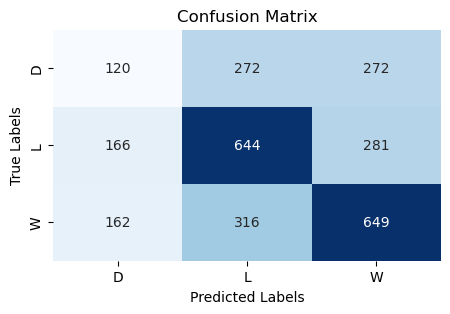

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
evaluate_model(ExtraTreesClassifier(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### Gradient Boosting

`Iterative Improvement`: It starts with a base estimator to make initial predictions and sequentially improves them by adding new models that correct the errors made by previous models.

`Gradient Descent`: The "gradient" in Gradient Boosting refers to the method of using gradient descent to minimize the loss when adding new models. For classification, the loss function typically used is log loss.

`Weak Learners`: Each new model is a decision tree, often with constraints such as a limited depth (shallow trees) to ensure they are "weak".

`Additive Model`: Each tree is added one at a time, and existing trees in the model are not changed. The gradient descent step determines the contribution of each tree to the final prediction, often called the learning rate.

`Multi-Class Classification`: For multi-class problems like W, D, and L, Gradient Boosting typically uses a one-vs-all (OvA) strategy where a separate binary classifier is fit for each class.

`Prediction`: Predictions are made by summing up the contributions of all trees in the ensemble. The final prediction is the class that has the highest combined score from all the individual binary classifiers.

Model: GradientBoostingClassifier
Accuracy: 0.5003469812630118
Precision: 0.5142225289149429
Recall: 0.5003469812630118
F1 Score: 0.5063100689540908

Classification Report for GradientBoostingClassifier:


,precision,recall,f1-score,support
D,0.279245,0.334337,0.304318,664.000000
L,0.583008,0.547204,0.564539,1091.000000
W,0.586077,0.552795,0.568950,1127.000000
accuracy,0.500347,0.500347,0.500347,0.500347
macro avg,0.482777,0.478112,0.479269,2882.000000
weighted avg,0.514223,0.500347,0.506310,2882.000000


Confusion Matrix for GradientBoostingClassifier


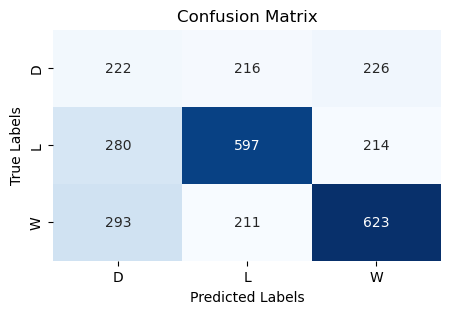

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
evaluate_model(GradientBoostingClassifier(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### Naive Bayes

It supports sample weight, but using sample weight will cause it to predict too many draws

`Probability Model`: The model assumes that the data for each class follows a Gaussian (normal) distribution. This assumption simplifies the calculation of probabilities and makes the model computationally efficient.

`Parameter Estimation`: It estimates the mean and variance of each feature for each class to describe the distribution. During training, these parameters are computed based on the training data.

`Bayes' Theorem`: GaussianNB applies Bayes' Theorem to compute the probability $ P(C_k \mid x) $ of each class $ C_k $ given a feature vector $ x $.

$$
P(C_k \mid x) = \frac{P(x \mid C_k) \cdot P(C_k)}{P(x)}
$$

`Class Prediction`: For a given test instance, the classifier calculates the probability $ P(C_k \mid x) $ for each class and picks the class with the highest probability as the predicted class.

Model: GaussianNB
Accuracy: 0.4823039555863983
Precision: 0.49261242292211843
Recall: 0.4823039555863983
F1 Score: 0.48677216313562677

Classification Report for GaussianNB:


,precision,recall,f1-score,support
D,0.280519,0.325301,0.301255,664.000000
L,0.545198,0.530706,0.537854,1091.000000
W,0.566667,0.527950,0.546624,1127.000000
accuracy,0.482304,0.482304,0.482304,0.482304
macro avg,0.464128,0.461319,0.461911,2882.000000
weighted avg,0.492612,0.482304,0.486772,2882.000000


Confusion Matrix for GaussianNB


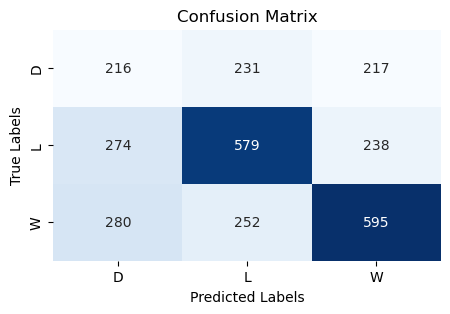

In [11]:
from sklearn.naive_bayes import GaussianNB
evaluate_model(GaussianNB(), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df, supports_sample_weight=False)

### K-Neighbours

The model's fit method does not support a sample_weight parameter

`Distance Measurement`: The classifier calculates the distance between the data point it needs to classify and all other points in the training set. Common distance metrics include Euclidean, Manhattan, and Minkowski.

`Nearest Neighbors Selection`: It then identifies the 'k' closest points, or 'neighbors,' based on the calculated distances. The number 'k' is a user-defined parameter and is crucial in determining how the model performs.

`Majority Voting`: The prediction for the new data point is made based on a majority vote of its nearest neighbors. Each neighbor gets a vote towards their class, and the class with the most votes is assigned to the data point in question.

`Handling Ties`: In case of a tie (where two or more classes receive the same number of votes), the model typically picks the class from the nearest point among the tied groups, although this can vary depending on the specific implementation.

Model: KNeighborsClassifier
Accuracy: 0.4437890353920888
Precision: 0.46067603024891174
Recall: 0.4437890353920888
F1 Score: 0.44793817457673707

Classification Report for KNeighborsClassifier:


,precision,recall,f1-score,support
D,0.266423,0.329819,0.294751,664.000000
L,0.493703,0.538955,0.515337,1091.000000
W,0.543153,0.418811,0.472946,1127.000000
accuracy,0.443789,0.443789,0.443789,0.443789
macro avg,0.434426,0.429195,0.427678,2882.000000
weighted avg,0.460676,0.443789,0.447938,2882.000000


Confusion Matrix for KNeighborsClassifier


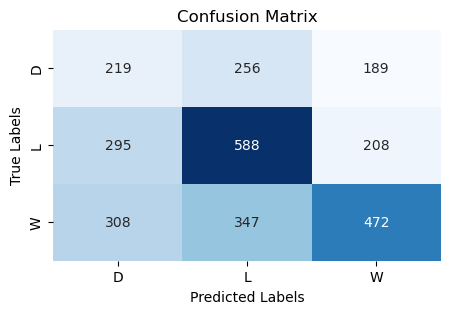

In [12]:
from sklearn.neighbors import KNeighborsClassifier
evaluate_model(KNeighborsClassifier(), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df, supports_sample_weight=False)

### Support Vector Machines

`Maximizing Margin`: SVC works by finding a hyperplane (in high-dimensional space) that best separates the classes with the maximum margin. The margin is the distance between the hyperplane and the nearest data points from each class, known as support vectors. The larger the margin, the lower the generalization error of the classifier.

`Handling Multi-Class`: By default, scikit-learn implements the one-vs-one (OvO) approach for multi-class classification with SVC. This involves training a separate classifier for every pair of classes:
- Wins vs. Draws
- Wins vs. Losses
- Draws vs. Losses

`Class Prediction`: During prediction, each binary classifier votes for one of the two classes it distinguishes. The final predicted class is the one that gets the most votes across all binary classifiers.

Model: SVC
Accuracy: 0.49826509368494104
Precision: 0.521564101835813
Recall: 0.49826509368494104
F1 Score: 0.5069503818780905

Classification Report for SVC:


,precision,recall,f1-score,support
D,0.293258,0.393072,0.335907,664.000000
L,0.587413,0.538955,0.562141,1091.000000
W,0.592331,0.520852,0.554297,1127.000000
accuracy,0.498265,0.498265,0.498265,0.498265
macro avg,0.491001,0.484293,0.484115,2882.000000
weighted avg,0.521564,0.498265,0.506950,2882.000000


Confusion Matrix for SVC


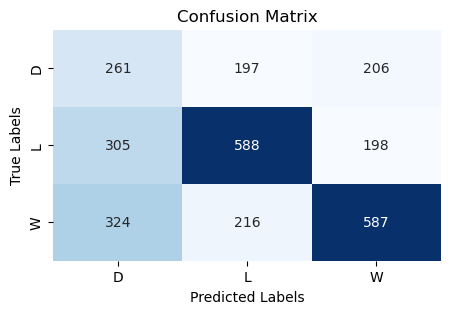

In [13]:
from sklearn.svm import SVC
evaluate_model(SVC(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

In [14]:
metrics_df = pd.DataFrame(model_metrics).T
metrics_df.to_csv('data/machine_learning/model_metrics.csv')

Proceed to deep_learning.ipynb